# Second part: Word2Vec and Visualising data
Word2Vec is a technique that converts words into dense, continuous vectors—commonly known as embeddings—that capture the semantic relationships between them. Unlike traditional methods such as one-hot encoding or TF‑IDF, which produce high-dimensional and sparse representations, Word2Vec generates low-dimensional vectors that reflect word meanings based on their context in large text corpora. This means that words with similar meanings, such as "good" and "excellent," will have vectors that are close together in the embedding space, enabling models to understand subtle nuances in language.

In our data processing pipeline, Word2Vec will serve as the second step after cleaning, normalization, and lemmatization. Once we have preprocessed our text, we will convert the tokens into meaningful embeddings using Word2Vec. These embeddings not only reduce the dimensionality of our feature space but also provide semantically rich representations that can enhance the performance of our sentiment analysis model. For now, we are focused on refining our data, setting the stage for later integration of these embeddings into our predictive models.

['I', 'absolutely', 'love', 'this', 'product', '.']
['The', 'service', 'was', 'terrible', 'and', 'disappointing', '.']
['It', 'was', 'okay', ',', 'nothing', 'special', '.']
['I', 'am', 'extremely', 'happy', 'with', 'the', 'results', '!']


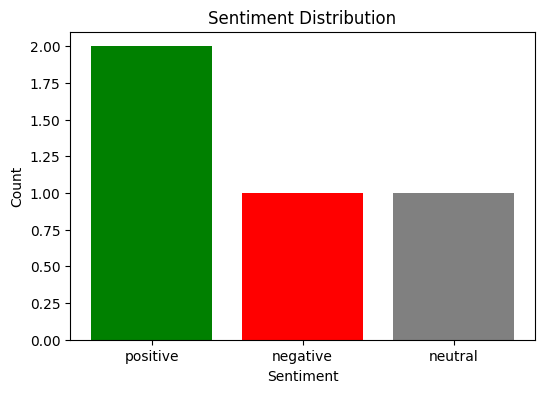

Embedding for 'love':
[ 0.00805391  0.00869487  0.01991474 -0.00894748 -0.00277853 -0.01463464
 -0.01939566 -0.01816051 -0.00204551 -0.01300658  0.00969946 -0.01232805
  0.00503837  0.00147888 -0.00678431 -0.00195845  0.01995825  0.01829177
 -0.00892366  0.01816605 -0.01128353  0.01186184 -0.00619444  0.0068635
  0.00603445  0.01380092 -0.00474777  0.01755007  0.01517886 -0.01909529
 -0.01601642 -0.01527579  0.00584651 -0.00558944 -0.01385904 -0.01625653
  0.01661836  0.00398098 -0.01865603 -0.00958543  0.00627348 -0.00942641
  0.01056169 -0.00846688  0.00528359 -0.01609137  0.01241977  0.00963778
  0.00157439  0.0060269 ]


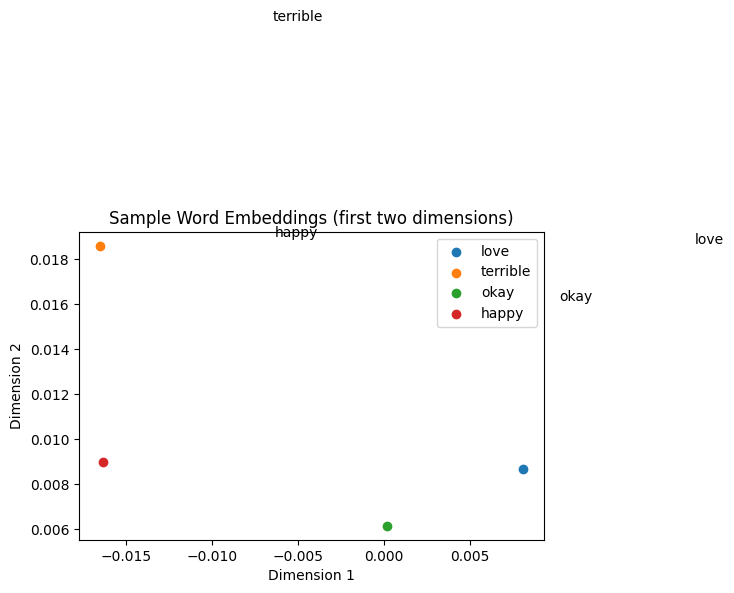

In [40]:
import json
import re
from bs4 import BeautifulSoup
import spacy
from spacy.tokens import Token
import os

# Ensure the folder exists (optional)
if not os.path.exists("processed_articles"):
    os.makedirs("processed_articles")

sample_json1 = {
    'text': "I absolutely love this product."
}
sample_json2 = {
    'text': "The service was terrible and disappointing."
}
sample_json3 = {
    'text': "It was okay, nothing special."
}
sample_json4 = {
    'text': "I am extremely happy with the results!"
}

# Save sample_json1, 2, 3, and 4 to files in the existing folder
with open("processed_articles/sample_article1.json", "w", encoding="utf-8") as f:
    json.dump(sample_json1, f, ensure_ascii=False, indent=4)
with open("processed_articles/sample_article2.json", "w", encoding="utf-8") as f:
    json.dump(sample_json2, f, ensure_ascii=False, indent=4)
with open("processed_articles/sample_article3.json", "w", encoding="utf-8") as f:
    json.dump(sample_json3, f, ensure_ascii=False, indent=4)
with open("processed_articles/sample_article4.json", "w", encoding="utf-8") as f:
    json.dump(sample_json4, f, ensure_ascii=False, indent=4)

# Load your spaCy model
nlp = spacy.load("en_core_web_sm")
# Define a custom extension for tokens
Token.set_extension("is_sentiment", default=False, force=True)

tokenized_sentences = []
for i in range(1, 5):
    # Load the sample JSON file (note the '.json' extension)
    with open(f"processed_articles/sample_article{i}.json", 'r', encoding='utf-8') as f:
        data = json.load(f)
    text = data['text']
    # Use BeautifulSoup to parse the text and remove unwanted tags
    soup = BeautifulSoup(text, "html.parser")
    for tag in soup(["script", "style"]):
        tag.decompose()  # Remove script and style elements completely

    # Extract text and remove extra whitespace/newlines
    text = soup.get_text(separator=" ")
    text = re.sub(r'\s+', ' ', text)

    # Process the cleaned text with spaCy
    doc = nlp(text)

    # Define a set of sentiment-bearing words (normalized to lowercase)
    sentiment_lemmas = {"not", "no", "nor", "very", "extremely", "really", "so", "too", "just", "but"}

    # Mark tokens as sentiment-bearing based on their lemma
    for token in doc:
        if token.lemma_.lower() in sentiment_lemmas:
            token._.is_sentiment = True

    cleaned_tokens = []

    # (Optional) Debug: Print tokenization
    print([token.text for token in doc])

    for token in doc:
        # Skip punctuation and numbers
        if token.is_punct or token.like_num:
            continue
        # Skip stop words UNLESS they are marked as sentiment-bearing.
        if token.is_stop and not token._.is_sentiment:
            continue
        lemma = token.lemma_.lower().strip()
        if lemma and lemma != '-pron-':
            cleaned_tokens.append(lemma)
        
    cleaned_text = " ".join(cleaned_tokens)
    data["cleaned_text"] = cleaned_text
    tokenized_sentences.append(cleaned_tokens)

import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# Example sentences and their sentiments for visualization
sentences = [
    "I absolutely love this product!",       # Positive
    "The service was terrible and disappointing.",  # Negative
    "It was okay, nothing special.",           # Neutral
    "I am extremely happy with the results!"  # Positive
]
sentiments = ['positive', 'negative', 'neutral', 'positive']

# Visualize sentiment distribution using a bar graph
from collections import Counter
sentiment_counts = Counter(sentiments)
categories = list(sentiment_counts.keys())
counts = list(sentiment_counts.values())

plt.figure(figsize=(6,4))
plt.bar(categories, counts, color=['green', 'red', 'gray'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

# Train a Word2Vec model on these tokenized sentences
model = Word2Vec(tokenized_sentences, vector_size=50, window=3, min_count=1, workers=2)

# Display the vector for one word as an example
word = 'love'
if word in model.wv:
    print(f"Embedding for '{word}':")
    print(model.wv[word])
else:
    print(f"Word '{word}' not found in the vocabulary.")

# Optional: Visualize word embeddings using a scatter plot (only for a few words)
words_to_plot = ['love', 'terrible', 'okay', 'happy']
vectors = [model.wv[w] for w in words_to_plot if w in model.wv]

plt.figure(figsize=(6,4))
for i, word in enumerate(words_to_plot):
    if word in model.wv:
        plt.scatter(vectors[i][0], vectors[i][1], marker='o', label=word)
        plt.text(vectors[i][0]+0.01, vectors[i][1]+0.01, word)
plt.title("Sample Word Embeddings (first two dimensions)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

As shown above we created a visual representation of clearly four sentence examples that convey sentiment (positive, negative, neutral, and positive again) through pyplot. We can see that once we apply that data pipeline we had from the first part of the notebook series, if we apply the word2vec model and train our data through there, the results are generally good (just for these 4 cases). Word2Vec will be the backbone of the model of this sentiment analysis project. 

Word2Vec will be used for feature representation - converting words into dense vector embeddings that capture semantic meanings. In our pipeline, we can train the Word2Vec model on the gathered data (corpus, or pre-trained embeddings, that has not yet been decided) to represent each word. The idea is that we use words with similar context ("happy", "joyful") end up in similar vector representations.

Additionally, traditional sentiment analysis often uses three labels (positive, negative, neutral). However, emotion classification (which is one of the bigger goals of this project, deteching them) requires more granularity. We would need to use the backed-up-by-psychology 6 basic emotions (anger, fear, joy, sadness, surprise, disgust). 

Public availability: GoEmotions is publicly available (with a taxonomy and a published paper), and another source is the Kaggle Emotion dataset (Twitter data with 6 emotions, as mentioned above). These can be combined or used separately for training and evaluation.

Even though that data has been labeled already, what's important to us is that we're taking that text and feeding it through Word2Vec to give us dense, low-dimensional vectors that capture their semantic relationships—essential for any downstream emotion classification model.

Our next goal is to grow from using a few manually created examples to leveraging a larger, real-world dataset—the Kaggle Emotion dataset. This dataset provides examples of six basic emotions: anger, fear, joy, love, sadness, and surprise. Although it doesn’t include a "neutral" label, we have two options to incorporate neutrality later:

1. <b>Dataset Augmentation</b>: We can supplement the Kaggle data with additional texts (e.g., generic news articles or other sources) that represent a neutral tone.
2. <b>Post-processing Thresholding</b>: Alternatively, after training a model on the six emotions, we can introduce a threshold mechanism where texts with low confidence for all emotion classes are re-classified as "neutral."

For now, we'll focus on converting our preprocessed text into embeddings with Word2Vec. Later, these embeddings will feed into deep learning architectures (like LSTMs or CNNs) for multi-class emotion classification. This staged approach allows us to first verify that our feature representation is effective before moving into the more complex model training phase.

# Disclaimer:
Emotion Dataset for Emotion Recognition Tasks by Parul Radney has a CC0 public Domain license, meaning "The person who associated a work with this deed has dedicated the work to the public domain by waiving all of his or her rights to the work worldwide under copyright law, including all related and neighboring rights, to the extent allowed by law.
You can copy, modify, distribute and perform the work, even for commercial purposes, all without asking permission. See Other Information below."

This is for educational purposes, but we will also need this Kaggle dataset in the future. 

In [41]:
import pandas as pd
#process the data for training the model
data = pd.read_csv('./kaggle_data/training.csv', encoding='utf-8')
data = data.dropna()
print(data.columns.values)
data.head()

['text' 'label']


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [42]:
#take each sentence from the text column and store as text_data
text_data = data['text'].values
#check to see if the data is stored correctly
print(text_data[:5])

#save labels. a classification label, with possible values including 
#sadness (0), joy (1), love (2), anger (3), fear (4).
labels = data['label'].values

total_count_per_label = {}
for label in labels:
    total_count_per_label[label] = total_count_per_label.get(label, 0) + 1
print(total_count_per_label)


['i didnt feel humiliated'
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'
 'im grabbing a minute to post i feel greedy wrong'
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'
 'i am feeling grouchy']
{0: 4666, 3: 2159, 2: 1304, 5: 572, 4: 1937, 1: 5362}


great, now let's push into our pipeline

In [43]:

import re
from bs4 import BeautifulSoup
import spacy
from spacy.tokens import Token

patterns = {
    r"\bim\b": "I'm",
    r"\byoure\b": "you're",
    r"\bdidnt\b": "didn't",
    r"\bdont\b": "don't",
    r"\bcan't\b": "can't",  # Already correct if typed correctly, but you can handle "cant"
    r"\bcant\b": "can't",
    r"\bwont\b": "won't",
    r"\bwouldnt\b": "wouldn't",
    r"\bshouldnt\b": "shouldn't",
    r"\bcouldnt\b": "couldn't",
    r"\bmustnt\b": "mustn't",
    r"\bwasnt\b": "wasn't",
    r"\bwerent\b": "weren't",
    r"\bhavent\b": "haven't",
    r"\bhasnt\b": "hasn't",
    r"\bill\b": "I'll",
    r"\bhes\b": "he's",
    r"\bshes\b": "she's",
    r"\bits\b": "it's",      # Use context to decide if it's possessive or a contraction
    r"\bthats\b": "that's",
    r"\bwhos\b": "who's",
    r"\bhows\b": "how's",
    r"\bwheres\b": "where's",
    r"\btheres\b": "there's",
    r"\byoure\b": "you're",
    r"\bwouldve\b": "would've",
    r"\bshouldve\b": "should've",
    r"\bcouldve\b": "could've",
    r"\bmightve\b": "might've",
    r"\bmustve\b": "must've",
    r"\bneednt\b": "needn't",
    r"\bshant\b": "shan't",
    r"\byall\b": "y'all"
}
# Define a set of sentiment-bearing words (normalized to lowercase)
sentiment_lemmas = {"not", "no", "nor", "very", "extremely", "really", "so", "too", "just", "but"}
# Load your spaCy model
nlp = spacy.load("en_core_web_sm")

tokenized_texts = []
for text in text_data:

    # Use BeautifulSoup to parse the text and remove unwanted tags
    soup = BeautifulSoup(text, "html.parser")
    for tag in soup(["script", "style"]):
        tag.decompose()  # Remove script and style elements completely

    # Extract text and remove extra whitespace/newlines
    text = soup.get_text(separator=" ")
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text)

    # Process the cleaned text with spaCy
    doc = nlp(text)

    # Mark tokens as sentiment-bearing based on their lemma
    for token in doc:
        if token.lemma_.lower() in sentiment_lemmas:
            token._.is_sentiment = True

    cleaned_tokens = []


    for token in doc:
        # Skip punctuation and numbers
        if token.is_punct or token.like_num:
            continue
        # Skip stop words UNLESS they are marked as sentiment-bearing.
        if token.is_stop and not token._.is_sentiment:
            continue
        lemma = token.lemma_.lower().strip()
        if lemma and lemma != '-pron-':
            cleaned_tokens.append(lemma)
    tokenized_texts.append(cleaned_tokens)

print(tokenized_texts[:5])


[['not', 'feel', 'humiliated'], ['feel', 'so', 'hopeless', 'so', 'damned', 'hopeful', 'just', 'care', 'awake'], ['grab', 'minute', 'post', 'feel', 'greedy', 'wrong'], ['feel', 'nostalgic', 'fireplace', 'know', 'property'], ['feel', 'grouchy']]


In [44]:
from gensim.models import Word2Vec
import numpy as np

# Assume tokenized_texts is your preprocessed list of token lists from earlier steps.
# Example:
# tokenized_texts = [
#     ['grab', 'minute', 'post', 'feel', 'greedy', 'wrong'],
#     ['another', 'example', 'text', ...],
#     ...
# ]
# And assume labels is defined from your data as:
# labels = data['label'].values
# where each label is an integer (0: sadness, 1: joy, 2: love, 3: anger, 4: fear)

# Train a custom Word2Vec model on our cleaned tokenized texts.
# sg=1 indicates that we're using the skip-gram model.
model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4, sg=1)
print("Custom Word2Vec model trained on the cleaned text.")

# Check if training is successful:
vocab_size = len(model.wv.index_to_key)
print("Vocabulary size:", vocab_size)

# Optionally, check similar words for a common token in the dataset.
if tokenized_texts and tokenized_texts[0]:
    test_word = tokenized_texts[0][0]
    if test_word in model.wv:
        print(f"Most similar words to '{test_word}':", model.wv.most_similar(test_word, topn=5))

# Save the trained model for later use.
model.save("word2vec_custom.model")
print("Word2Vec model saved as 'word2vec_custom.model'.")

# Function to compute an averaged word vector for a given text
def get_text_vector(model, text):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Return a zero vector if none of the words are in the model's vocabulary.
        return np.zeros(model.vector_size)

# Build training data: Compute sentence embeddings from tokenized_texts.
X = []
for tokens in tokenized_texts:
    # Join tokens to form a cleaned sentence string.
    text = " ".join(tokens)
    vec = get_text_vector(model, text)
    X.append(vec)
X = np.array(X)

# Convert labels to a numpy array.
y = np.array(labels)

print("Training features shape:", X.shape)
print("Labels shape:", y.shape)

# Check label distribution.
total_count_per_label = {}
for label in labels:
    total_count_per_label[label] = total_count_per_label.get(label, 0) + 1
print("Label distribution:", total_count_per_label)


Custom Word2Vec model trained on the cleaned text.
Vocabulary size: 11870
Most similar words to 'not': [('really', 0.9613196849822998), ('person', 0.958556592464447), ('just', 0.9582537412643433), ('thing', 0.9579960107803345), ('talk', 0.9542369842529297)]
Word2Vec model saved as 'word2vec_custom.model'.
Training features shape: (16000, 100)
Labels shape: (16000,)
Label distribution: {0: 4666, 3: 2159, 2: 1304, 5: 572, 4: 1937, 1: 5362}


The code above trains a Word2Vec model to generate embeddings (i.e. numerical representations) for words. These embeddings capture semantic and syntactic relationships and are used here to create an averaged vector for each sentence. This by itself is not a classifier.
In a typical NLP classification pipeline, you might use these word or sentence embeddings as input features to a classifier (e.g., logistic regression, an LSTM, or a CNN). In a deep learning setup, you might even use the embeddings to initialize an embedding layer. The actual classification model would be built on top of these features.

Ok now let's now use test.csv, to see how our model performed

In [45]:
data = pd.read_csv('./kaggle_data/test.csv', encoding='utf-8')
data = data.dropna()
print(data.columns.values)
data.head()
#take each sentence from the text column and store as text_data
text_data = data['text'].values
#check to see if the data is stored correctly
print(text_data[:5])

#save labels. a classification label, with possible values including 
#sadness (0), joy (1), love (2), anger (3), fear (4).
labels = data['label'].values

total_count_per_label = {}
for label in labels:
    total_count_per_label[label] = total_count_per_label.get(label, 0) + 1
print(total_count_per_label)


patterns = {
    r"\bim\b": "I'm",
    r"\byoure\b": "you're",
    r"\bdidnt\b": "didn't",
    r"\bdont\b": "don't",
    r"\bcan't\b": "can't",  # Already correct if typed correctly, but you can handle "cant"
    r"\bcant\b": "can't",
    r"\bwont\b": "won't",
    r"\bwouldnt\b": "wouldn't",
    r"\bshouldnt\b": "shouldn't",
    r"\bcouldnt\b": "couldn't",
    r"\bmustnt\b": "mustn't",
    r"\bwasnt\b": "wasn't",
    r"\bwerent\b": "weren't",
    r"\bhavent\b": "haven't",
    r"\bhasnt\b": "hasn't",
    r"\bill\b": "I'll",
    r"\bhes\b": "he's",
    r"\bshes\b": "she's",
    r"\bits\b": "it's",      # Use context to decide if it's possessive or a contraction
    r"\bthats\b": "that's",
    r"\bwhos\b": "who's",
    r"\bhows\b": "how's",
    r"\bwheres\b": "where's",
    r"\btheres\b": "there's",
    r"\byoure\b": "you're",
    r"\bwouldve\b": "would've",
    r"\bshouldve\b": "should've",
    r"\bcouldve\b": "could've",
    r"\bmightve\b": "might've",
    r"\bmustve\b": "must've",
    r"\bneednt\b": "needn't",
    r"\bshant\b": "shan't",
    r"\byall\b": "y'all"
}
# Define a set of sentiment-bearing words (normalized to lowercase)
sentiment_lemmas = {"not", "no", "nor", "very", "extremely", "really", "so", "too", "just", "but"}
# Load your spaCy model
nlp = spacy.load("en_core_web_sm")

tokenized_texts_test = []
for text in text_data:

    # Use BeautifulSoup to parse the text and remove unwanted tags
    soup = BeautifulSoup(text, "html.parser")
    for tag in soup(["script", "style"]):
        tag.decompose()  # Remove script and style elements completely

    # Extract text and remove extra whitespace/newlines
    text = soup.get_text(separator=" ")
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text)

    # Process the cleaned text with spaCy
    doc = nlp(text)

    # Mark tokens as sentiment-bearing based on their lemma
    for token in doc:
        if token.lemma_.lower() in sentiment_lemmas:
            token._.is_sentiment = True

    cleaned_tokens = []


    for token in doc:
        # Skip punctuation and numbers
        if token.is_punct or token.like_num:
            continue
        # Skip stop words UNLESS they are marked as sentiment-bearing.
        if token.is_stop and not token._.is_sentiment:
            continue
        lemma = token.lemma_.lower().strip()
        if lemma and lemma != '-pron-':
            cleaned_tokens.append(lemma)
    tokenized_texts_test.append(cleaned_tokens)



['text' 'label']
['im feeling rather rotten so im not very ambitious right now'
 'im updating my blog because i feel shitty'
 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her'
 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived'
 'i was feeling a little vain when i did this one']
{0: 581, 1: 695, 4: 224, 3: 275, 2: 159, 5: 66}


# Time for Testing!

In [46]:
# --- Load the saved Word2Vec model ---
model = Word2Vec.load("word2vec_custom.model")
print("Loaded Word2Vec model.")

# --- Define function to compute averaged sentence vector ---
def get_text_vector(model, text):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# --- Compute sentence embeddings for the test data ---
X_test = []
for tokens in tokenized_texts_test:
    sentence = " ".join(tokens)
    vec = get_text_vector(model, sentence)
    X_test.append(vec)
X_test = np.array(X_test)
y_test = np.array(labels)

print("Test features shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# --- Inspect a sample embedding ---
print("Sample test embedding (first document):", X_test[0])

Loaded Word2Vec model.
Test features shape: (2000, 100)
Test labels shape: (2000,)
Sample test embedding (first document): [-0.15636468  0.08886372  0.17411056  0.03493501 -0.09423061 -0.34414095
  0.21622635  0.44835234 -0.22907026 -0.15757337  0.05814926 -0.24230561
 -0.0208857   0.10016131  0.16470869 -0.24015532  0.22420709 -0.25026694
 -0.18764581 -0.7586993   0.28094658  0.04797461  0.41222331 -0.18037355
 -0.02670058  0.10102841 -0.13118973  0.09165822 -0.44220373  0.05701194
  0.12882866 -0.06738121  0.33426166 -0.553626   -0.01324908  0.26879749
  0.07777556 -0.27157253 -0.06395032 -0.23795585 -0.01417048 -0.12155668
 -0.09685532  0.00442475  0.12207128 -0.19363078 -0.1276149   0.06649942
  0.01010351  0.2787011   0.07260402  0.01657733 -0.14223389 -0.09651614
 -0.01301575  0.04614772  0.11471353 -0.01476422 -0.14832295  0.19926897
  0.00987065 -0.16950199  0.23735593 -0.00833503 -0.07504991  0.22979884
 -0.01109067  0.25749984 -0.38571569  0.20777416  0.20881306  0.31147578
 

## Summary of Our Embedding Pipeline and Next Steps

### What We Did
- We built a custom Word2Vec model from our preprocessed text data.
- We processed the test data through the same pipeline and generated averaged sentence embeddings.
- Although this step didn't create a classifier, it proved that our embeddings work—our pipeline is successfully converting raw text into meaningful numerical representations.

### How Can We Improve It?
- **Pre-Trained vs. Custom Word2Vec:**
  - **Pre-Trained Models:**  
    For example, the Google News Word2Vec model contains around 3 million words and phrases. These models offer robust, general-purpose embeddings that cover a vast vocabulary.
  - **Our Custom Model:**  
    Our model has learned from our specific dataset (with a vocabulary size of around 11,870 unique tokens), capturing domain-specific nuances that pre-trained models might miss.
- **Which Should We Use?**
  - Use our custom embeddings if domain-specific language and context are critical to your application.
  - Use a pre-trained model (or fine-tune one) if you need broad coverage and robust general language understanding.
  - Alternatively, a combination of both approaches may yield the best results.

### Next Steps: Model Creation, Training, and Evaluation
1. **Model Creation:**  
   Build a classifier that uses these embeddings as input features. Consider deep learning models like LSTMs, CNNs, or a hybrid approach, with a softmax layer for classifying emotions.
2. **Model Training:**  
   - Split your labeled data into training, validation, and test sets.
   - Train the classifier on your training set, using the embeddings to represent your text.
3. **Model Evaluation:**  
   - Evaluate your model on the validation and test sets.
   - Use metrics like accuracy, F1-score, precision, and recall to assess performance.
4. **Iteration and Improvement:**  
   - Experiment with different architectures and hyperparameters.
   - Consider whether integrating pre-trained embeddings or fine-tuning them could boost performance.

Even though one could say this was pointless, we got more familiarised with Word2Vec. Additionally, the data that we have can be used for our actual model learning, testing and validation, but we learned how to unsupervisedly train our word embedding for converting text to vectors to feed into our model.

# Great stuff! 🚀🚀🚀🚀